In [1]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')

import numpy as np
from analysis import analysis, emg, plot, model
import scipy as sp
from pathlib import Path

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

import matplotlib.pyplot as plt

image_path = Path("/Users/spencer/phd/phd/images/more_results/gmm_diffs/")

%matplotlib inline

In [2]:
subjects = analysis.load_subjects()

In [3]:
import pandas as pd
trajectory_df = pd.read_pickle("../trajectory_dataframe.pkl")
mean_rewards = 1 / trajectory_df.groupby(level=['subject']).mean()["reward"]

## compute euclidean diffs for each subject -- closest means, look at subsequent covariance differences

In [4]:
subject_diffs = []
for subject_idx in range(len(subjects)):
    log_models = model.load_log_trial_models(subject_idx)
    models = []
    for m in log_models:
        models.append(model.log_model(m))
    model_diffs = []
    model_mean_pairs = model.closest_pairs_euclidean(log_models)
    for model_idx, mean_pair in enumerate(model_mean_pairs):
        component_diffs = []
        for i, component_pair in enumerate(mean_pair):
            # model x --> model y
            # paired components
            component_diffs.append(analysis.frobenius_difference(models[model_idx].covariances[component_pair[0]], models[model_idx+1].covariances[component_pair[1]]))
        model_diffs.append(component_diffs)
    subject_diffs.append(model_diffs)
    
diff_rewards = []
mean_diffs = []
for i, model_diffs in enumerate(subject_diffs):
    diff_rewards.append(mean_rewards[i])
    # mean of the differences between subsequent models
    mean_diffs.append(np.mean(model_diffs))

In [21]:
mean_total_variance = []
for subject_idx in range(len(subjects)):
    log_models = model.load_log_trial_models(subject_idx)
    models = []
    tvm = 0
    for m in log_models:
        tv = 0
        for c in m.covariances_:
            tv += np.trace(c)
    tvm += tv/5
    mean_total_variance.append(tvm)

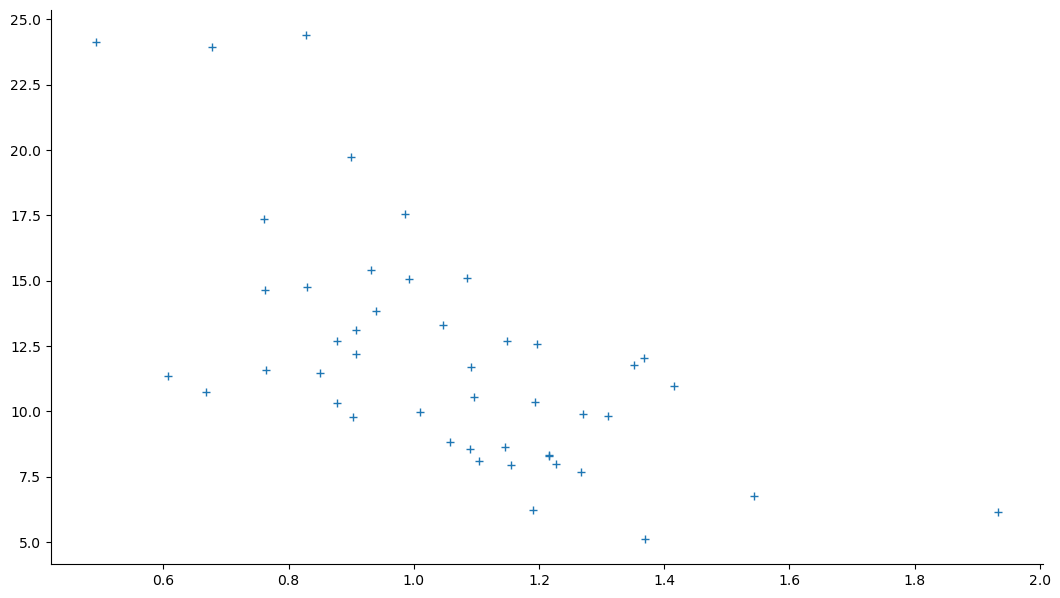

In [23]:
plt.plot(mean_rewards, mean_total_variance)

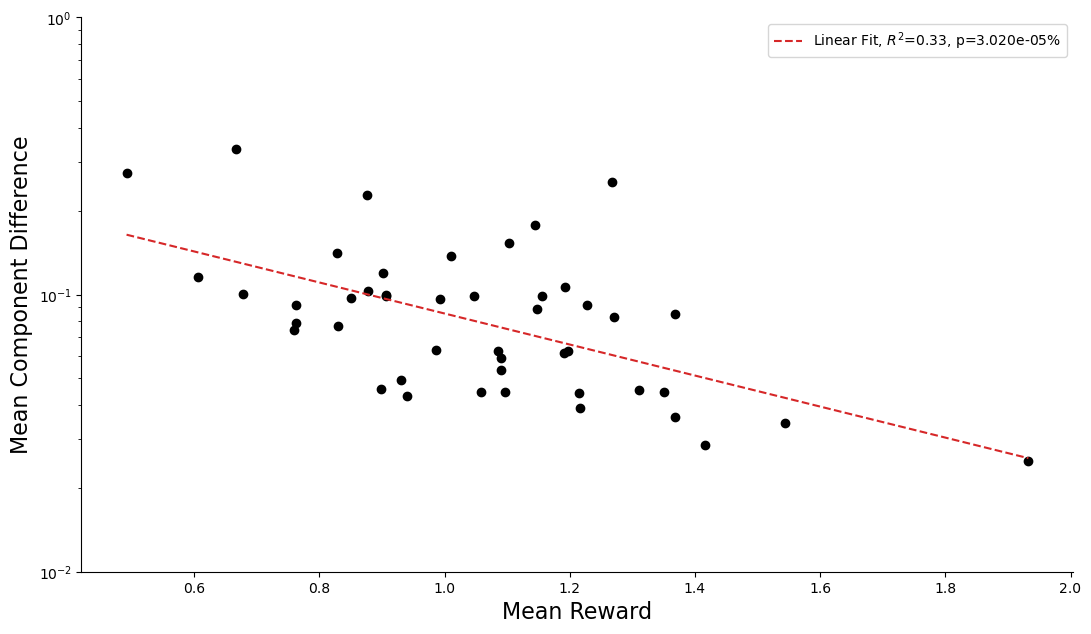

In [39]:
fig = plt.figure()
fig.tight_layout()
# plt.plot(diff_rewards,mean_diffs,"ro")
norm_diff = [md/mtv for md, mtv in zip(mean_diffs,mean_total_variance)]
plt.semilogy(diff_rewards,norm_diff,"ko")
r = analysis.linear_fit(diff_rewards,np.log(norm_diff))
x = np.linspace(np.min(diff_rewards),np.max(diff_rewards),100)
plt.gca().plot(x, np.exp(r.intercept + r.slope*x),"--", color="tab:red", label=f"Linear Fit, $R^2$={plot.format_positional(r.rvalue**2)}, p={plot.format_scientific(r.pvalue)}%")
# plot.plot_linear_fit(x,r,plt.gca())
plt.ylabel("Mean Component Difference")
plt.xlabel("Mean Reward")
plt.ylim([0.01,1])
plt.legend()

In [40]:
plot.save_figure(fig, "mean_gmm_differences", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmm_diffs/mean_gmm_differences.pdf


## wasserstein pairs per subject